In [2]:
import splitfolders
import numpy as np
import seaborn
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [2]:
# Split folders into train and test
import splitfolders

input_folder = 'C:/Users/pc/Desktop/AI_Project/images/combined/'

splitfolders.ratio(input_folder, output="C:/Users/pc/Desktop/AI_Project/splitted_images",
    seed=42, ratio = (.8,.0,.2),
    group_prefix = None
)

Copying files: 11088 files [00:30, 365.13 files/s]


In [3]:
# Image dataset path
train_dataset_path = 'C:/Users/pc/Desktop/AI_Project/splitted_images/train'
validation_dataset_path = 'C:/Users/pc/Desktop/AI_Project/splitted_images/test'

In [4]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 16

#32 dene


In [5]:
# Loading datasets and apply augmentations

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                    target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 8870 images belonging to 3 classes.


In [6]:
# load the validation model

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 2218 images belonging to 3 classes.


In [7]:
# getting the label mappings

labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label mappings for classes present in training and test datasets \n")

for key, value in labels.items():
    print(f"{key} : {value}")


Label mappings for classes present in training and test datasets 

0 : middle
1 : old
2 : young


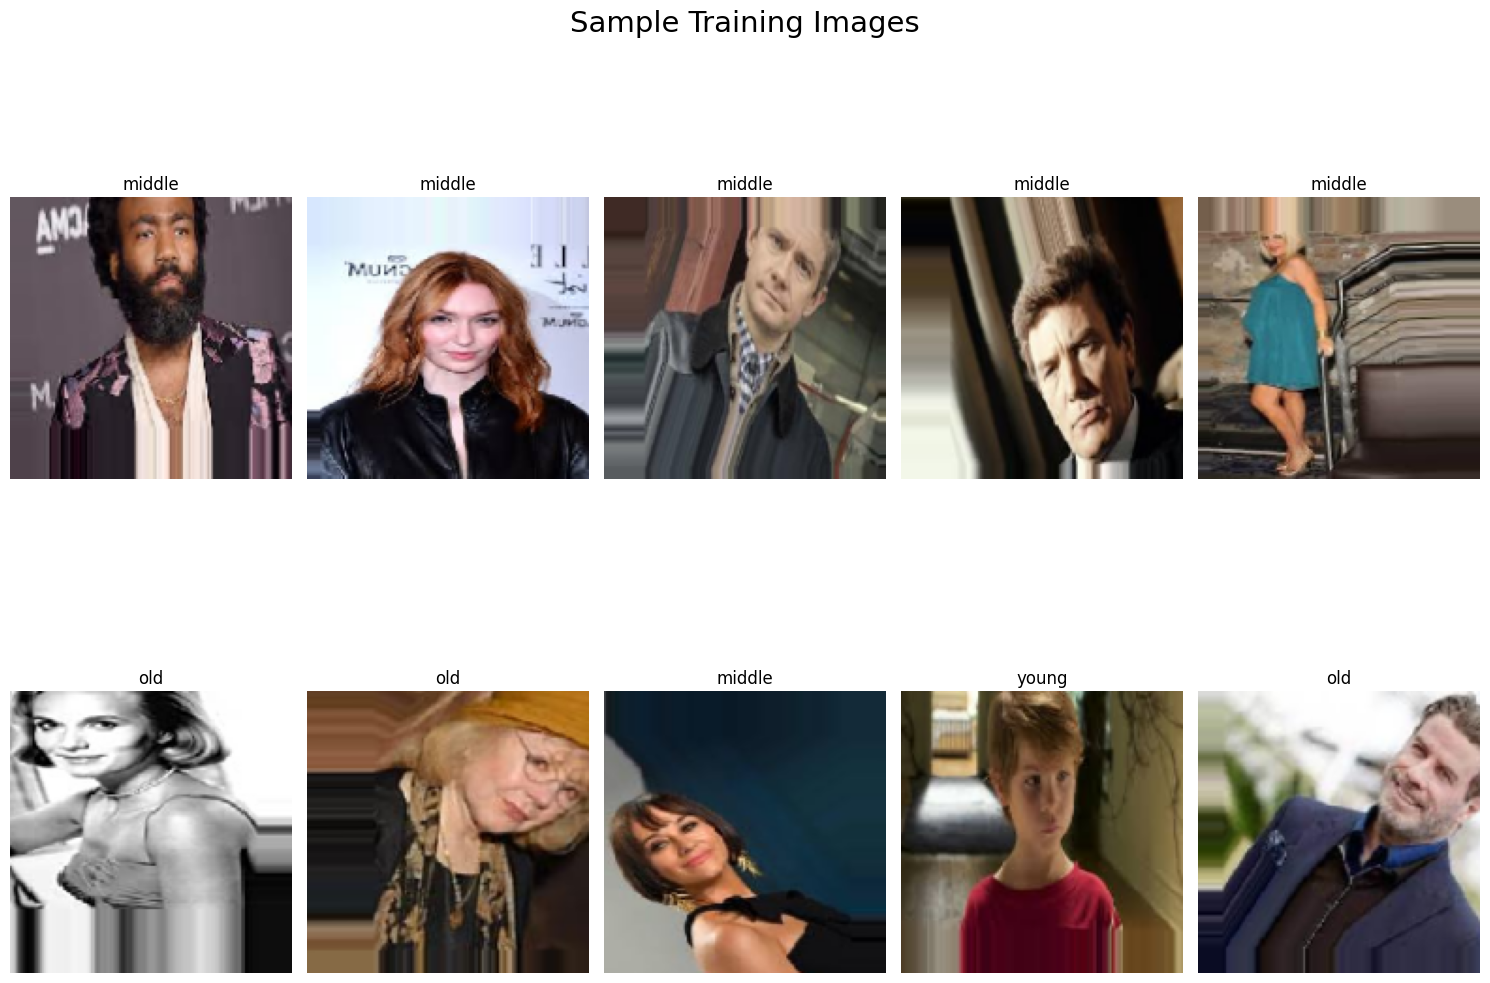

In [7]:
# Plotting Sample Training Images

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(labels), activation="softmax")
])


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=["accuracy"])

EPOCHS = 100

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // BATCH_SIZE)


In [11]:
# Save the model
model.save("model_yeni.h5")


In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

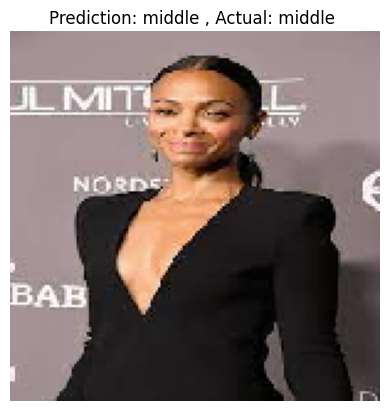

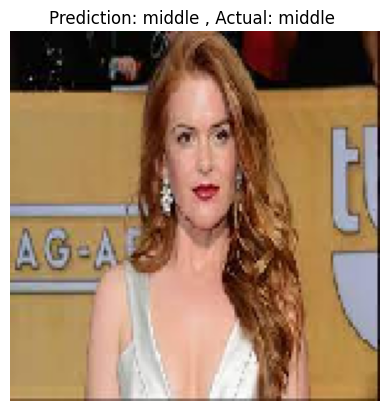

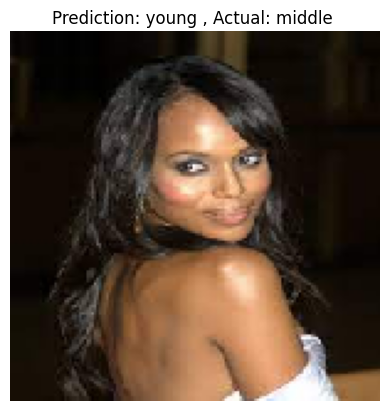

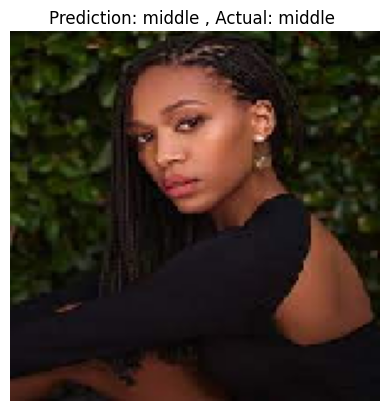

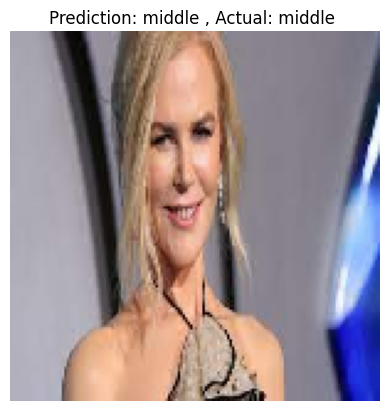

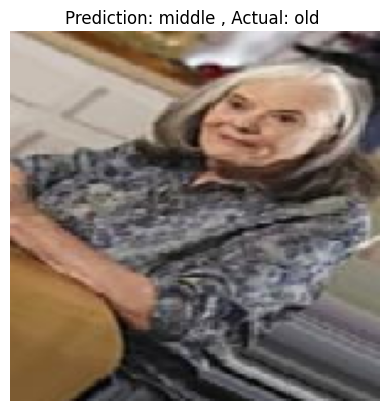

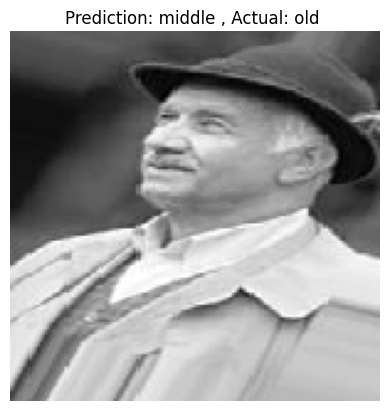

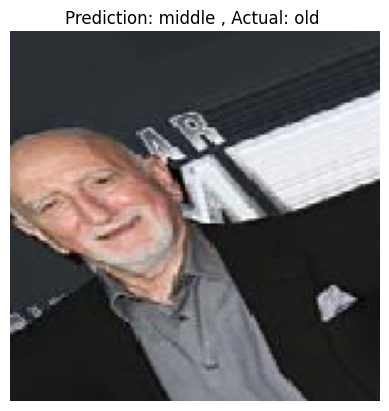

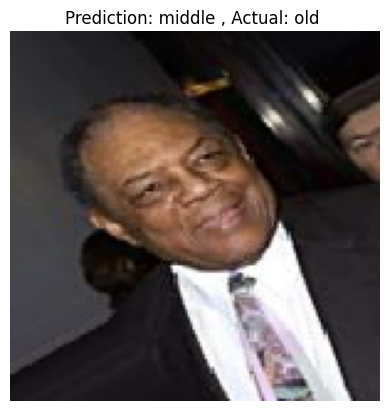

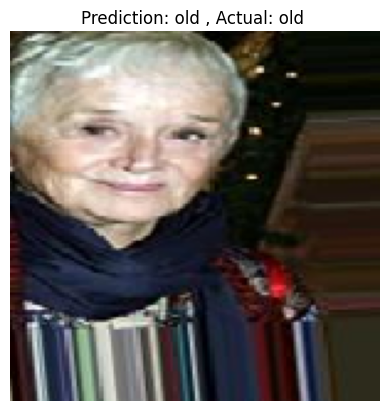

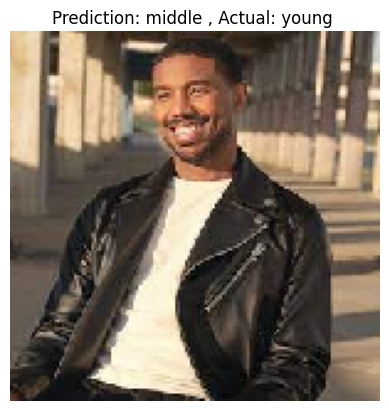

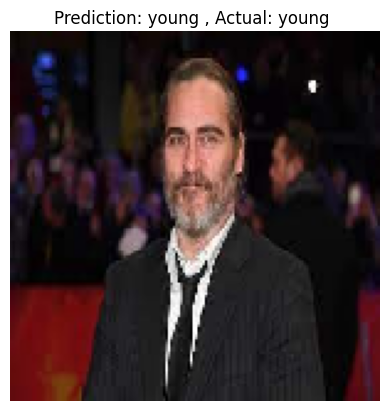

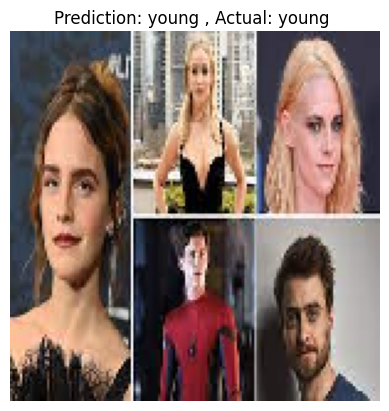

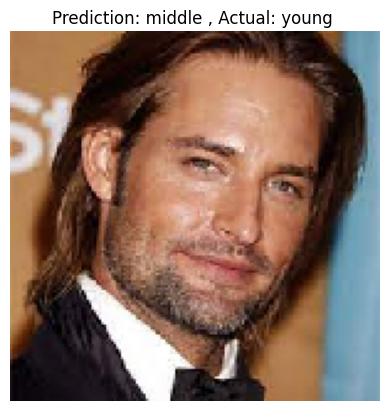

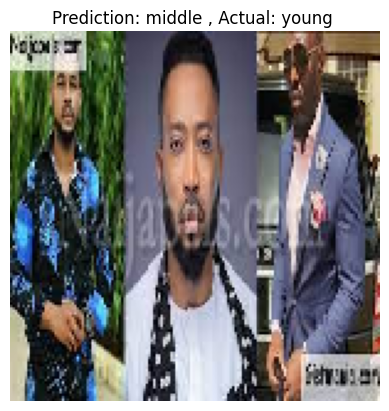

In [16]:
def predict_images(test_folder, model_path, labels):
    model = load_model(model_path)

    for class_folder in os.listdir(test_folder):
        class_folder_path = os.path.join(test_folder, class_folder)

        if os.path.isdir(class_folder_path):
            image_count = 0
            for image_file in os.listdir(class_folder_path):
                if image_count >= 5:
                    break

                if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_folder_path, image_file)

                    # Load and preprocess the image
                    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                    img_array = img_to_array(img)
                    img_array = img_array / 255.0
                    img_array = np.expand_dims(img_array, axis=0)

                    # Predict the class
                    prediction = model.predict(img_array)
                    predicted_class = np.argmax(prediction)
                    actual_class = [key for key, value in labels.items() if value == class_folder][0]

                    # Display the image with the prediction and actual class labels
                    plt.imshow(img)
                    plt.title(f"Prediction: {labels[predicted_class]} , Actual: {labels[actual_class]} ")
                    plt.axis('off')
                    plt.show()

                    image_count += 1


# Test dataset path
test_dataset_path = 'C:/Users/pc/Desktop/AI_Project/splitted_images/test'

# Load the label mappings
labels = {value: key for key, value in train_generator.class_indices.items()}

# Predict images in the test folder
model_path = 'model_epoch100.h5'
predict_images(test_dataset_path, model_path, labels)
